In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from prettytable import PrettyTable

In [ ]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.EMNIST(root='.', train=True, download=True, split="letters",
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])), batch_size=64, shuffle=True, num_workers=2)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.EMNIST(root='.', train=False, split="letters", transform=transforms.Compose([
        transforms.ToTensor(),
    ])), batch_size=64, shuffle=True, num_workers=2)

100%|██████████| 561753746/561753746 [00:29<00:00, 18867952.35it/s]


Extracting ./EMNIST/raw/gzip.zip to ./EMNIST/raw


In [ ]:
class Net(nn.Module):
    def __init__(self,  use_stn=False):
        super(Net, self).__init__()

        # Whether to use stn block or not
        self.use_stn = use_stn

        self.net = nn.Sequential(                                               #                                       -------------|
            nn.Conv2d(1, 10, kernel_size=5),                            # Convolution layer 1                     |
            nn.MaxPool2d(2),                                                      # Max pooling layer 1                     |
            nn.ReLU(True),                                                           # ReLU function 1                            |
            nn.Conv2d(10, 20, kernel_size=5),                         # Convolution layer 2                      |  CNN
            nn.MaxPool2d(2),                                                     # Max pooling layer 2                      |  MODEL
            nn.ReLU(True),                                                          # ReLU function 2                             |  ARCHITECTURE
            nn.Flatten(start_dim=1),                                         # Flatten function                             |
            nn.Linear(320, 50),                                                  # Fully connected layer 1                 |
            nn.ReLU(True),                                                         # ReLU function 3                              |
            nn.Linear(50, 26)                                                     # Fully connected layer 2                 |
        )                                                                                      #                                              ----------|

        if use_stn:
            # Spatial transformer localization-network
            self.localization = nn.Sequential(                                    #                     -------------|
                nn.Conv2d(1, 8, kernel_size=7),                      # Convolution layer 1              |
                nn.MaxPool2d(2, stride=2),                             # Max poolilng layer 1             |
                nn.ReLU(True),                                                      # ReLU function 1                  |
                nn.Conv2d(8, 10, kernel_size=5),                    # Convolution layer 2              |
                nn.MaxPool2d(2, stride=2),                             # Max pooling layer 2              |
                nn.ReLU(True)                                                       # ReLU function 2                  | STN
            )                                                                                                 #                                  | LOCALIZATION
                                                                                                              #                                  | NETWORK
          # Regressor for the 3 * 2 affine matrix                                                                     |
            self.fc_loc = nn.Sequential(                                                   #                                  |
                nn.Linear(10 * 3 * 3, 32),                                # Fully connected layer 1          |
                nn.ReLU(True),                                                       # ReLU function 3                  |
                nn.Linear(32, 3 * 2)                                          # Fully connected layer 3          |
            )                                                                                              #                         ---------|

            # Initialize the weights/bias with identity transformation
            self.fc_loc[2].weight.data.zero_()
            self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):

        # Pass the image through localization network
        xs = self.localization(x)
        xs = torch.flatten(xs, start_dim=1)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        # Run the grid generator and sampler functions
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):

        # Pass the image through STN block
        if self.use_stn:
          x = self.stn(x)

        # Pass the image through the network
        x = self.net(x)
        return F.log_softmax(x, dim=1)

In [ ]:

# Training function
def train(epoch, model):

    # Set model to train mode
    model.train()

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    train_loss = []
    total_images = 0
    correct = 0

    for batch_idx, (data, target) in pbar:

        # Initialize optimizer to zero gradient
        optimizer.zero_grad()

        # Pass batch of image to the model
        data, target = data.to(device), (target-1).to(device)
        output = model(data)

        # Calculate loss value
        loss = F.nll_loss(output, target)
        train_loss.append(loss.item())

        # Run backpropagation and update model using optimizer
        loss.backward()
        optimizer.step()

        # Count the correct number of predictions for accuracy calculation
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
        total_images += len(target)

        # Display training loss and training accuracy
        pbar.set_description("Train loss: {:.4f}, Train accuracy: {}/{} {:.2f}%".format(np.mean(train_loss), correct, total_images, correct/total_images*100))

    return model, np.mean(train_loss), correct/total_images*100


# Test function
def test(model):

    # Set model to eval mode
    model.eval()
    with torch.no_grad(): # No gradient is used during testing/evaluation
        test_loss = []
        correct = 0
        total_images = 0
        for data, target in test_loader:

            # Get output for one batch of images
            data, target = data.to(device), (target-1).to(device)
            output = model(data)

            # Calculate loss value
            loss = F.nll_loss(output, target).item()
            test_loss.append(loss)

            # Count the correct number of predictions for accuracy calculation
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            total_images += len(target)

        # Calculate average loss
        # test_loss /= len(test_loader.dataset)

        # Display test loss and test accuracy
        print('Test loss: {:.4f}, Test accuracy: {}/{} ({:.2f}%)\n'.format(np.mean(test_loss), correct, total_images, correct/total_images*100))

    return np.mean(test_loss), correct/total_images*100

In [ ]:
# Create model without STN
model = Net().to(device)

# Initialize optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train model for 15 epochs
n_epochs = 15
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(1, n_epochs+1):
    print("Epoch " + str(epoch) + "/" + str(n_epochs))

    model, loss, accuracy = train(epoch, model)
    train_loss.append(loss)
    train_accuracy.append(accuracy)

    loss, accuracy = test(model)
    test_loss.append(loss)
    test_accuracy.append(accuracy)

Epoch 1/15


Train loss: 2.3723, Train accuracy: 41639/124800 33.36%: 100%|██████████| 1950/1950 [00:35<00:00, 54.67it/s]


Test loss: 1.0554, Test accuracy: 14129/20800 (67.93%)

Epoch 2/15


Train loss: 0.7584, Train accuracy: 95447/124800 76.48%: 100%|██████████| 1950/1950 [00:26<00:00, 73.84it/s]


Test loss: 0.5646, Test accuracy: 17142/20800 (82.41%)

Epoch 3/15


Train loss: 0.4987, Train accuracy: 105256/124800 84.34%: 100%|██████████| 1950/1950 [00:26<00:00, 72.89it/s]


Test loss: 0.4437, Test accuracy: 17928/20800 (86.19%)

Epoch 4/15


Train loss: 0.4118, Train accuracy: 108496/124800 86.94%: 100%|██████████| 1950/1950 [00:26<00:00, 72.36it/s]


Test loss: 0.3874, Test accuracy: 18230/20800 (87.64%)

Epoch 5/15


Train loss: 0.3659, Train accuracy: 110196/124800 88.30%: 100%|██████████| 1950/1950 [00:26<00:00, 73.54it/s]


Test loss: 0.3743, Test accuracy: 18352/20800 (88.23%)

Epoch 6/15


Train loss: 0.3374, Train accuracy: 111256/124800 89.15%: 100%|██████████| 1950/1950 [00:26<00:00, 72.47it/s]


Test loss: 0.3381, Test accuracy: 18482/20800 (88.86%)

Epoch 7/15


Train loss: 0.3164, Train accuracy: 112061/124800 89.79%: 100%|██████████| 1950/1950 [00:26<00:00, 73.41it/s]


Test loss: 0.3223, Test accuracy: 18669/20800 (89.75%)

Epoch 8/15


Train loss: 0.3014, Train accuracy: 112647/124800 90.26%: 100%|██████████| 1950/1950 [00:26<00:00, 72.34it/s]


Test loss: 0.3062, Test accuracy: 18808/20800 (90.42%)

Epoch 9/15


Train loss: 0.2873, Train accuracy: 113142/124800 90.66%: 100%|██████████| 1950/1950 [00:26<00:00, 72.31it/s]


Test loss: 0.2949, Test accuracy: 18813/20800 (90.45%)

Epoch 10/15


Train loss: 0.2769, Train accuracy: 113498/124800 90.94%: 100%|██████████| 1950/1950 [00:26<00:00, 72.63it/s]


Test loss: 0.2832, Test accuracy: 18904/20800 (90.88%)

Epoch 11/15


Train loss: 0.2677, Train accuracy: 113907/124800 91.27%: 100%|██████████| 1950/1950 [00:26<00:00, 72.56it/s]


Test loss: 0.2806, Test accuracy: 18943/20800 (91.07%)

Epoch 12/15


Train loss: 0.2603, Train accuracy: 114145/124800 91.46%: 100%|██████████| 1950/1950 [00:27<00:00, 72.06it/s]


Test loss: 0.2787, Test accuracy: 18987/20800 (91.28%)

Epoch 13/15


Train loss: 0.2523, Train accuracy: 114437/124800 91.70%: 100%|██████████| 1950/1950 [00:27<00:00, 71.47it/s]


Test loss: 0.2782, Test accuracy: 18980/20800 (91.25%)

Epoch 14/15


Train loss: 0.2460, Train accuracy: 114637/124800 91.86%: 100%|██████████| 1950/1950 [00:26<00:00, 73.20it/s]


Test loss: 0.2647, Test accuracy: 19048/20800 (91.58%)

Epoch 15/15


Train loss: 0.2402, Train accuracy: 114931/124800 92.09%: 100%|██████████| 1950/1950 [00:26<00:00, 73.12it/s]


Test loss: 0.2641, Test accuracy: 19045/20800 (91.56%)



In [ ]:
# Create model with STN
model_stn = Net(use_stn=True).to(device)

# Initialize optimizer
optimizer = optim.SGD(model_stn.parameters(), lr=0.01)

# Train model for 15 epochs
n_epochs = 15
train_loss_stn = []
train_accuracy_stn = []
test_loss_stn = []
test_accuracy_stn = []

for epoch in range(1, n_epochs+1):
    print("Epoch " + str(epoch) + "/" + str(n_epochs))

    model_stn, loss, accuracy = train(epoch, model_stn)
    train_loss_stn.append(loss)
    train_accuracy_stn.append(accuracy)

    loss, accuracy = test(model_stn)
    test_loss_stn.append(loss)
    test_accuracy_stn.append(accuracy)

Epoch 1/15


  0%|          | 0/1950 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4358: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
Train loss: 1.8352, Train accuracy: 58638/124800 46.99%: 100%|██████████| 1950/1950 [00:30<00:00, 64.74it/s]


Test loss: 0.6577, Test accuracy: 16557/20800 (79.60%)

Epoch 2/15


Train loss: 0.5146, Train accuracy: 104627/124800 83.84%: 100%|██████████| 1950/1950 [00:30<00:00, 64.28it/s]


Test loss: 0.4017, Test accuracy: 18158/20800 (87.30%)

Epoch 3/15


Train loss: 0.3665, Train accuracy: 110205/124800 88.31%: 100%|██████████| 1950/1950 [00:29<00:00, 65.18it/s]


Test loss: 0.3330, Test accuracy: 18532/20800 (89.10%)

Epoch 4/15


Train loss: 0.3110, Train accuracy: 112233/124800 89.93%: 100%|██████████| 1950/1950 [00:29<00:00, 65.05it/s]


Test loss: 0.2847, Test accuracy: 18923/20800 (90.98%)

Epoch 5/15


Train loss: 0.2788, Train accuracy: 113443/124800 90.90%: 100%|██████████| 1950/1950 [00:30<00:00, 64.73it/s]


Test loss: 0.2695, Test accuracy: 18981/20800 (91.25%)

Epoch 6/15


Train loss: 0.2557, Train accuracy: 114395/124800 91.66%: 100%|██████████| 1950/1950 [00:29<00:00, 65.18it/s]


Test loss: 0.2858, Test accuracy: 18871/20800 (90.73%)

Epoch 7/15


Train loss: 0.2404, Train accuracy: 114855/124800 92.03%: 100%|██████████| 1950/1950 [00:30<00:00, 64.90it/s]


Test loss: 0.2436, Test accuracy: 19083/20800 (91.75%)

Epoch 8/15


Train loss: 0.2274, Train accuracy: 115332/124800 92.41%: 100%|██████████| 1950/1950 [00:29<00:00, 65.26it/s]


Test loss: 0.2360, Test accuracy: 19205/20800 (92.33%)

Epoch 9/15


Train loss: 0.2189, Train accuracy: 115719/124800 92.72%: 100%|██████████| 1950/1950 [00:30<00:00, 64.94it/s]


Test loss: 0.2238, Test accuracy: 19270/20800 (92.64%)

Epoch 10/15


Train loss: 0.2090, Train accuracy: 116026/124800 92.97%: 100%|██████████| 1950/1950 [00:30<00:00, 64.49it/s]


Test loss: 0.2149, Test accuracy: 19330/20800 (92.93%)

Epoch 11/15


Train loss: 0.2032, Train accuracy: 116213/124800 93.12%: 100%|██████████| 1950/1950 [00:30<00:00, 64.30it/s]


Test loss: 0.2190, Test accuracy: 19258/20800 (92.59%)

Epoch 12/15


Train loss: 0.1969, Train accuracy: 116479/124800 93.33%: 100%|██████████| 1950/1950 [00:30<00:00, 63.99it/s]


Test loss: 0.2136, Test accuracy: 19287/20800 (92.73%)

Epoch 13/15


Train loss: 0.1922, Train accuracy: 116591/124800 93.42%: 100%|██████████| 1950/1950 [00:29<00:00, 65.05it/s]


Test loss: 0.2144, Test accuracy: 19286/20800 (92.72%)

Epoch 14/15


Train loss: 0.1877, Train accuracy: 116779/124800 93.57%: 100%|██████████| 1950/1950 [00:30<00:00, 64.16it/s]


Test loss: 0.2040, Test accuracy: 19404/20800 (93.29%)

Epoch 15/15


Train loss: 0.1829, Train accuracy: 116932/124800 93.70%: 100%|██████████| 1950/1950 [00:29<00:00, 65.71it/s]


Test loss: 0.2112, Test accuracy: 19353/20800 (93.04%)



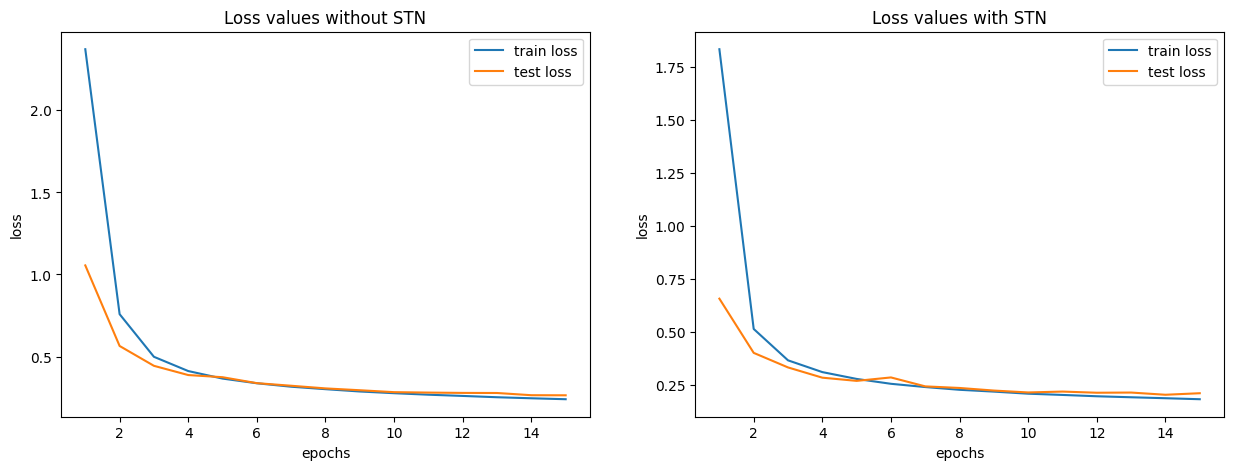

In [ ]:
# Plot the loss values
epochs = range(1, n_epochs+1)

fig, ax = plt.subplots(1, 2, figsize=(15,5))

# Loss values without STN
ax[0].plot(epochs, train_loss, label="train loss")
ax[0].plot(epochs, test_loss, label="test loss")
ax[0].legend()
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("loss")
ax[0].set_title("Loss values without STN")

# Loss values with STN
ax[1].plot(epochs, train_loss_stn, label="train loss")
ax[1].plot(epochs, test_loss_stn, label="test loss")
ax[1].legend()
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("loss")
ax[1].set_title("Loss values with STN")

plt.show()

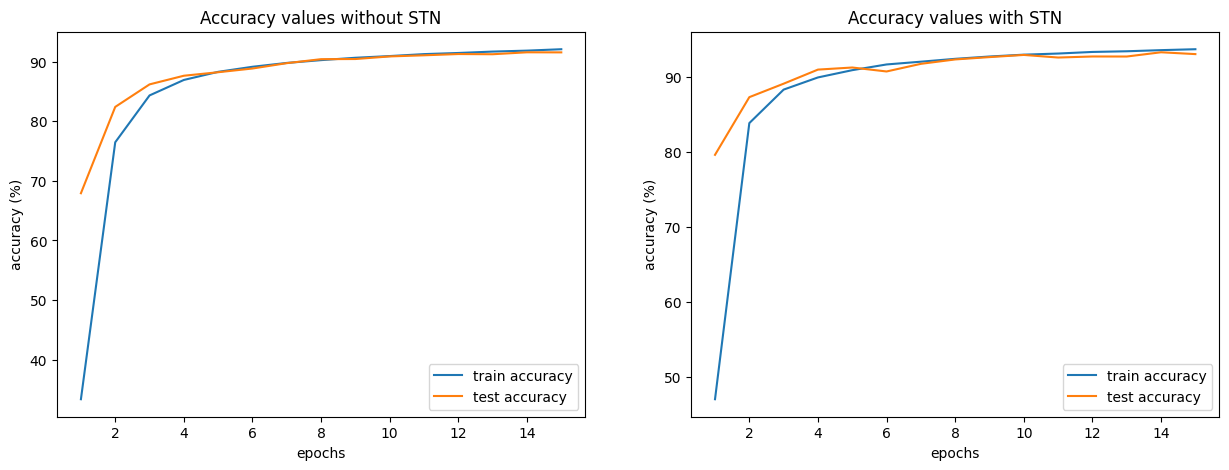

In [ ]:
# Plot the accuracy values
epochs = range(1, n_epochs+1)

fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].plot(epochs, train_accuracy, label="train accuracy")
ax[0].plot(epochs, test_accuracy, label="test accuracy")
ax[0].legend()
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("accuracy (%)")
ax[0].set_title("Accuracy values without STN")

ax[1].plot(epochs, train_accuracy_stn, label="train accuracy")
ax[1].plot(epochs, test_accuracy_stn, label="test accuracy")
ax[1].legend()
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("accuracy (%)")
ax[1].set_title("Accuracy values with STN")

plt.show()

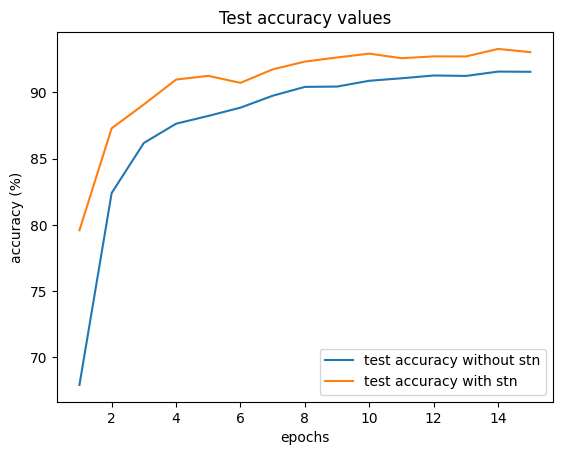

In [ ]:
# Plot the test accuracy with stn vs without stn
plt.plot(epochs, test_accuracy, label="test accuracy without stn")
plt.plot(epochs, test_accuracy_stn, label="test accuracy with stn")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.title("Test accuracy values")
plt.show()

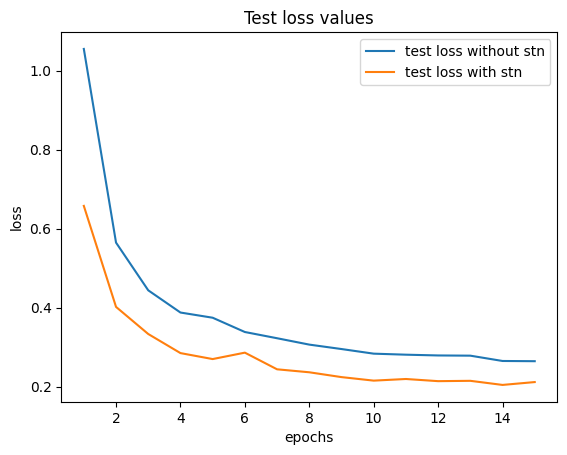

In [ ]:
# Plot the test loss with stn vs without stn
plt.plot(epochs, test_loss, label="test loss without stn")
plt.plot(epochs, test_loss_stn, label="test loss with stn")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Test loss values")
plt.show()

In [ ]:
# Display the final loss and accuracy of the models
x = PrettyTable()
x.field_names = ["Model", "Train accuracy (%)", "Test accuracy (%)", "Train loss", "Test loss"]
x.add_rows(
    [
        ["Without STN", round(train_accuracy[-1], 3), round(test_accuracy[-1], 3), round(train_loss[-1], 3), round(test_loss[-1], 3)],
        ["With STN", round(train_accuracy_stn[-1], 3), round(test_accuracy_stn[-1], 3), round(train_loss_stn[-1], 3), round(test_loss_stn[-1], 3)]
    ]
)
print(x)

+-------------+--------------------+-------------------+------------+-----------+
|    Model    | Train accuracy (%) | Test accuracy (%) | Train loss | Test loss |
+-------------+--------------------+-------------------+------------+-----------+
| Without STN |       92.092       |       91.562      |    0.24    |   0.264   |
|   With STN  |       93.696       |       93.043      |   0.183    |   0.211   |
+-------------+--------------------+-------------------+------------+-----------+
